RBF and MMDLoss classes are copied from https://github.com/yiftachbeer/mmd_loss_pytorch with some changes
Some inspiration from https://www.kaggle.com/code/onurtunali/maximum-mean-discrepancy

In [81]:
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as trans

In [82]:
class RBF(nn.Module):

    def __init__(self, bandwidth=None): #bandwidth = sigma
        super().__init__()
        self.bandwidth_multipliers = torch.tensor([0.5, 1, 5, 10, 20, 40], dtype = torch.float32)
        self.bandwidth = bandwidth

    def get_bandwidth(self):
        if self.bandwidth is None:
            return 1
        return self.bandwidth

    def forward(self, X):
        L2_distances = torch.cdist(X, X) ** 2 
        return torch.exp(-0.5 * L2_distances[None, ...] / ((self.get_bandwidth() * self.bandwidth_multipliers)**2)[:, None, None]).sum(dim=0) - 6*torch.eye(len(X), dtype=torch.float32)

class MMDLoss(nn.Module):

    def __init__(self, kernel=RBF()):
        super().__init__()
        self.kernel = kernel

    def forward(self, X, Y):
        K = self.kernel(torch.vstack([X, Y]))

        X_size = X.shape[0]
        Y_size = Y.shape[0]
        XX = K[:X_size, :X_size].sum() / (X_size**2-X_size)
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].sum() / (Y_size**2-Y_size)
        return XX - 2 * XY + YY

Parameters:

In [83]:
N_batch = 500
N_input = 50
N_epochs = 50

Load MNIST data:

In [84]:
trainds = torchvision.datasets.MNIST(root='./data', 
                                          train=True, 
                                          transform=trans.ToTensor(),  
                                          download=True)
trainldr = torch.utils.data.DataLoader(dataset=trainds, 
                                           batch_size=N_batch, 
                                           shuffle=True)

First four images in the training data:

60000


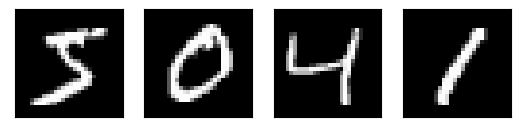

In [85]:
print(len(trainds))

plt.gray()
for r in range(4):
    ax = plt.subplot(1, 4, r+1)
    img = trainds[r][0]
    plt.imshow(img.detach().reshape(28,28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Define model:

In [86]:
class network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(N_input, 1000)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(1000, 500)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(500, 500)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(500, 1000)
        self.act4 = nn.ReLU()
        self.output = nn.Linear(1000, 28*28)
        self.act_output = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act4(self.hidden4(x))
        x = self.act_output(self.output(x))
        return x
    
model = network()

loss_fn = MMDLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

Train model:

In [87]:
np.random.seed(123)
torch.manual_seed(123)

for epoch in range(N_epochs):
    for idx, (x, lbls) in enumerate(trainldr): #lbls are the digits
        x = x.reshape(-1, 28*28) #-1 is N_batch (first dimension of x)
    
        x_input = np.random.uniform(-0.5,0.5,N_batch*N_input)
        x_input = torch.tensor(x_input, dtype=torch.float32).reshape(N_batch, N_input)

        x_output = model(x_input)

        loss = loss_fn(x, x_output)
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.09461140632629395
Finished epoch 1, latest loss 0.08050942420959473
Finished epoch 2, latest loss 0.0476076602935791
Finished epoch 3, latest loss 0.04360795021057129
Finished epoch 4, latest loss 0.037697553634643555
Finished epoch 5, latest loss 0.024941682815551758
Finished epoch 6, latest loss 0.024332284927368164
Finished epoch 7, latest loss 0.017060518264770508
Finished epoch 8, latest loss 0.014885902404785156
Finished epoch 9, latest loss 0.0160825252532959
Finished epoch 10, latest loss 0.01196146011352539
Finished epoch 11, latest loss 0.009937524795532227
Finished epoch 12, latest loss 0.00863504409790039
Finished epoch 13, latest loss 0.009343385696411133
Finished epoch 14, latest loss 0.010234832763671875
Finished epoch 15, latest loss 0.010119915008544922
Finished epoch 16, latest loss 0.011343717575073242
Finished epoch 17, latest loss 0.006402730941772461
Finished epoch 18, latest loss 0.008415937423706055
Finished epoch 19, latest loss 

Visualize model outputs:

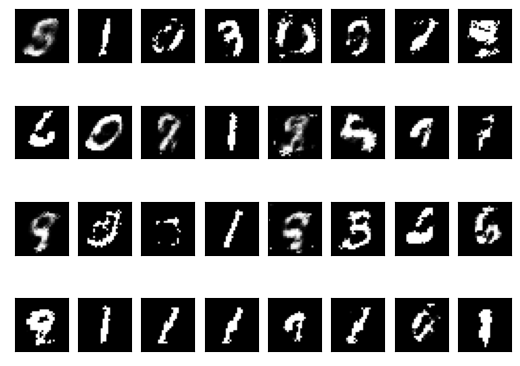

In [89]:
np.random.seed(0)

noises = []

plt.gray()
for r in range(4):
  for c in range(8):
    ax = plt.subplot(4, 8, r * 8 + c + 1)
    noise = np.random.uniform(-0.5,0.5,N_input)
    noise = torch.tensor(noise, dtype=torch.float32).reshape(1,-1)
    test = model(noise)
    plt.imshow(test.detach().squeeze().cpu().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    noises.append(noise)
plt.show()

Nearest neighbours to make sure model doesnt simply copy training data:

tensor([[4.9864]])
tensor([[3.1664]])
tensor([[7.3456]])
tensor([[6.0270]])


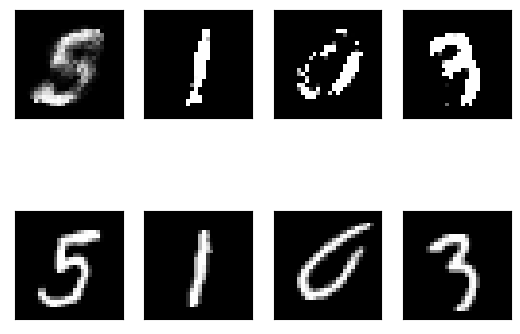

In [90]:
for i in range(4):
    ax = plt.subplot(2, 4, i+1)
    with torch.no_grad():
        test = model(noises[i])
    plt.imshow(test.detach().squeeze().cpu().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    smallest = 0 #index such that MMD of image and train image is smallest using euclidean dist
    dist = float('inf')
    for j in range(len(trainds)):
        dist_new = torch.cdist(test,trainds[j][0].reshape(-1,28*28))
        if dist_new < dist: 
            dist = dist_new
            smallest = j
    ax = plt.subplot(2, 4, 5+i)
    plt.imshow(trainds[smallest][0].detach().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    print(dist)
plt.show()